In [1]:
from datetime import datetime
from glob import glob
import json
import os

import cv2
from keras import losses, Model, optimizers, metrics
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, DepthwiseConv2D, Dropout, Flatten, Input, Reshape
from keras.losses import SparseCategoricalCrossentropy
# from keras.metrics import MeanSquaredError, SparseCategoricalAccuracy
from keras.utils import plot_model
from livelossplot import PlotLossesKeras, PlotLossesKerasTF
from matplotlib import pyplot as plt
from numpy import interp
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.python.ops.image_ops_impl import *

from helper.dataset_mkr import *
from helper.eval_function import *
from helper.gpu_memory import *
from helper.model import *
from helper.model_visualizer import *
from helper.save import *

2022-11-11 11:34:59.334232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 11:34:59.449597: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 11:35:00.001624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-11 11:35:00.001673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [2]:
# load tensorboard
%load_ext tensorboard


In [3]:
"""
0 CPU
1 필요한 만큼 메모리를 런타임에 할당
2 GPU에 할당되는 전체 메모리 크기를 제한
"""
set_gpu_memory(1)

1 Physical GPUs, 1 Logical GPUs


2022-11-11 11:35:01.093800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 11:35:01.098218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 11:35:01.098459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 11:35:01.099104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [205]:
MODEL_VERSION = f"v2.1"
SAVE_PATH = f"OUT/{MODEL_VERSION}"

MIN, MAX = 0, 255

CLASS = 23
# RAW_CLASS = 23
# CLASS = RAW_CLASS+1  ## 1: BACKGROUND


# 1. DATASET

In [5]:
data_dir = f"/media/z/0/MVPC10/DATA/v1.1/RAW/03"
# file = f"label_1248_cnt.csv"
file = f"/media/z/0/MVPC10/DATA/LABEL/v2.1_FINAL_REFINED.csv"
df = pd.read_csv(file)
# df.sort_values(by=df.keys()[0], inplace=True, ascending=True)
print(df)


                path                                              label
0      1650315736806                                     [[0, 0, 0, 0]]
1      1650315796123                                     [[0, 0, 0, 0]]
2      1650315856514                                     [[0, 0, 0, 0]]
3      1650315917006                                     [[0, 0, 0, 0]]
4      1650315976418                                     [[0, 0, 0, 0]]
...              ...                                                ...
86493  1661954116964  [[25, 41, 40, 67], [38, 32, 50, 60], [54, 43, ...
86494  1661954176336                                     [[0, 0, 0, 0]]
86495  1661954236769                                     [[0, 0, 0, 0]]
86496  1661954296445                [[15, 19, 31, 40], [26, 7, 33, 23]]
86497  1661954356730                                 [[13, 18, 31, 37]]

[86498 rows x 2 columns]


In [6]:
df.empty

False

In [7]:
df.values[:,1].dtype

dtype('O')

In [8]:
df1 = v2_1_data_mkr(df, z_value=2)
df1.head

<bound method NDFrame.head of                 path  label
0      1650315796123      0
1      1650315917006      0
2      1650316036754      0
3      1650316156301      0
4      1650316276225      0
...              ...    ...
67461  1661954056432      9
67462  1661954116964      4
67463  1661954236769      0
67464  1661954296445      2
67465  1661954356730      1

[67466 rows x 2 columns]>

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

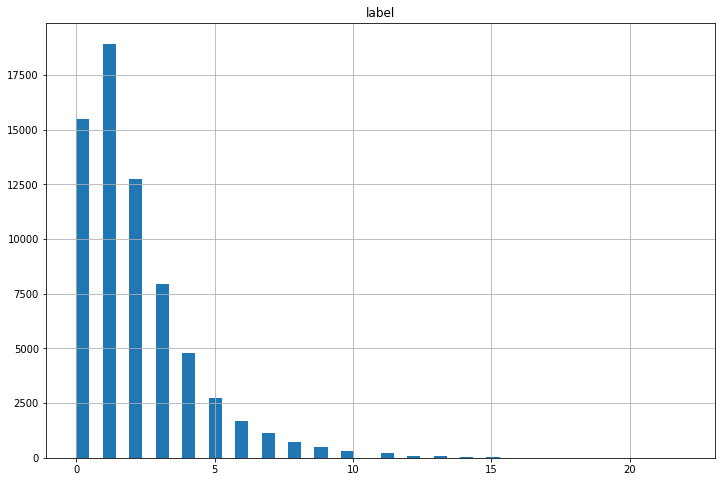

In [9]:
df1.hist(column="label", bins=CLASS*2, figsize=(12, 8))

In [10]:
df1['label'].value_counts().describe()

count       20.000000
mean      3373.300000
std       5772.821449
min          1.000000
25%         30.250000
50%        404.500000
75%       3258.250000
max      18938.000000
Name: label, dtype: float64

In [11]:
# df1.to_csv(f"test.csv", index=False)

### 1.2 AUGMENT

In [12]:
# ---------------------------------------------------------------- SHUFFLE DATA
SHUFFLE_DATA = 1
if SHUFFLE_DATA == 1:
    df1 = df1.sample(frac=1).reset_index(drop=True)
# df

In [13]:
## DROP ERROR
# df1 = df[df.iloc[:, 1] > 0]
# df1.head

### 1.4 DATA to TENSOR

In [14]:
data_full_path = f"/media/z/0/MVPC10/DATA/03_PROCESSED"

data, label = df_to_tensor(df1, data_full_path)

0
10000
20000
30000
40000
50000
60000


In [15]:
data = np.array(data)
data = data.reshape(data.shape[0], 80, 80, 1)
print(data.shape)

label = np.array(label)
label = label.reshape(label.shape[0], 1, 1, 1)
print(label.shape)

H, W = data.shape[1], data.shape[2]
print(H, W)


(67466, 80, 80, 1)
(67466, 1, 1, 1)
80 80


In [16]:
np.unique(label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 21, 22])

### 1.5 PROCESS

In [17]:
# set(data.reshape(-1))

In [18]:
## ---------------------------------------------------------------- SHUFFLE
# seed = 99
# np.random.seed(seed)
# np.random.shuffle(data)
# # np.random.seed(seed)
# np.random.shuffle(label)

## ---------------------------------------------------------------- LABEL NORMALIZE
# norm_label = label/CLASS
norm_label = label  ## NO NORMALIZE
# norm_label.dtype

## ---------------------------------------------------------------- DATA NORMALIZE
# print(data[0][0])
norm_data = data/MAX
# norm_data = data.astype("float")/MAX
# print(norm_data[0][0])


## ---------------------------------------------------------------- SPLIT
split1 = int(len(label)*0.96)
X1, X2 = norm_data[:split1], norm_data[split1:]
Y1, Y2 = norm_label[:split1], norm_label[split1:]
## VAL SPLIT
split2 = int(len(label)*0.9)
# X1, val_data = X1[:split2], X1[split2:]
# X2, val_label = X2[:split2], X2[split2:]



In [19]:
print(X1.shape)
print(Y1.shape)
print(X2.shape)
print(Y2.shape)

(64767, 80, 80, 1)
(64767, 1, 1, 1)
(2699, 80, 80, 1)
(2699, 1, 1, 1)


# 2. TRAIN

In [229]:
def bottleneck(name, input, filter=32, size=3, stride=1, activation='elu', dropout=0.25):
    x = Conv2D(filter*2, 1, strides=stride, padding='same', activation=activation, name=f"{name}_C")(input)
    x = DepthwiseConv2D(size, padding='same', activation=activation, name=f"{name}_DW_C")(x)
    x = Conv2D(filter, 1, 1, padding='same', name=f"{name}_PW_C")(x)
    x = Dropout(dropout, name=f"{name}_DO0")(x)

    x = Add(name=f"{name}_ADD")([input, x])

    return x

In [260]:
LOAD_MODEL = 0
MODEL_NAME = f"mobileNet"
TIME = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}"

if LOAD_MODEL == 0:
    def build_model(hp):
        ## -------------------------------------------------------------------------------- MODEL
        ## ---------------------------------------------------------------- SETUP
        # size = input_shape - layer_shape + 1
        ## con(filter, (size), stride, padding, activation, name, input)
        # bottleneck(name, input, add=1, filter0=32, size0=3, stride0=1, padding0='same', activation='elu', dropout=0.25, skip=0, filter1=32, size1=1, stride1=1, padding1='valid')
        inc = make_inc()

        ## ---------------------------------------------------------------- IN
        input = Input(shape=(H, W, 1))
        ## ---------------------------------------------------------------- HEAD
        filter = hp.Choice('filter', values=[16, 32, 64, 128, 256])
        size = hp.Choice('size', values=[3, 5, 7, 9, 11])
        stride = hp.Choice('stride', values=[1, 2])

        f = filter
        x = Conv2D(f, size, strides=stride, name=f'{inc()}')(input)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        ## ---------------------------------------------------------------- BODY
        f = 16
        x = Conv2D(f, 11, strides=1, name=f'{inc()}')(x)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        f = 16
        x = Conv2D(f, 9, strides=1, name=f'{inc()}')(x)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        f = 32
        x = Conv2D(f, 7, strides=1, name=f'{inc()}')(x)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        f = 32
        x = Conv2D(f, 5, strides=1, name=f'{inc()}')(x)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        f = 64
        x = Conv2D(f, 3, strides=1, name=f'{inc()}')(x)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        f = 64
        x = Conv2D(f, 3, strides=1, name=f'{inc()}')(x)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        f = 128
        x = Conv2D(f, 3, strides=2, name=f'{inc()}')(x)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        f = 192
        x = Conv2D(f, 3, strides=2, name=f'{inc()}')(x)
        x = bottleneck(f'{inc()}', x, f, 3, 1, 'elu', 0.25)

        # x = res_block(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
        # x = res_block(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
        # x = res_block(32, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
        # x = res_block(32, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
        # x = res_block(16, 11, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
        # x = res_block(8, 13, 1, 'valid', 'elu', 0.25, f'{inc()}', x)


        ## ---------------------------------------------------------------- TAIL
        # x = bottleneck(f'{inc()}', x, 1, 64, 3, 2, 'same', 'elu', 0.25)
        # x = Conv2D(1, 3, strides=2, name=f'{inc()}')(x)
        # x = tf.reduce_mean(x, (1, 2))  #, axis=None, keepdims=False, name=None)
        # x = Dropout(.5)(x)

        ## ---------------------------------------------------------------- OUT
        output = Conv2D(1, x.shape[1], strides=1, name=f'{inc()}')(x)

        model = Model(input, output)

        ## -------------------------------------------------------------------------------- COMPILE
        ## ---------------------------------------------------------------- OPTIMIZER
        # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #         initial_learning_rate=0.001,
        #         decay_steps=100000,
        #         decay_rate=0.96,
        #         staircase=True)

        # lr_schedule = k.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4,
        #                                                  decay_steps=EPOCH,
        #                                                  )

        # optimizer = optimizers.Adam(learning_rate=lr_schedule)
        optimizer = optimizers.Adam(learning_rate=0.0001)

        ## ---------------------------------------------------------------- LOSS
        # def adaptive_loss():
        #     pass
        # loss = losses.MeanAbsoluteError()
        # loss = losses.BinaryCrossentropy()
        loss = losses.MeanSquaredError()
        # loss = losses.SparseCategoricalCrossentropy()
        # loss = losses.BinaryFocalCrossentropy(  #apply_class_balancing=False,
        # alpha=0.25,
        # gamma=2.0,
        # from_logits=False,
        # label_smoothing=0.0,
        # axis=-1,
        # reduction=losses_utils.ReductionV2.AUTO,
        # name='binary_focal_crossentropy'
        # )

        ## ---------------------------------------------------------------- METRICS
        metrics = ['accuracy']
        # metrics = [SparseCategoricalAccuracy]
        # metrics = [metrics.MeanSquaredError()]

        ## ---------------------------------------------------------------- COMPILE
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return model


elif LOAD_MODEL == 1:
    model_num = -1
    model_path_last = sorted(glob(f"{SAVE_PATH}/model/*.h5"))[model_num]
    model = tf.keras.models.load_model(model_path_last)

model.summary()

Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_137 (InputLayer)         [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 1 (Conv2D)                     (None, 66, 66, 16)   3616        ['input_137[0][0]']              
                                                                                                  
 2_C (Conv2D)                   (None, 66, 66, 32)   544         ['1[0][0]']                      
                                                                                                  
 2_DW_C (DepthwiseConv2D)       (None, 66, 66, 32)   320         ['2_C[0][0]']                    
                                                                                           

In [273]:
import keras_tuner as kt

EPOCH = 64
BATCH = 32
ES = 4
# ES = EPOCH//4
es = EarlyStopping(monitor="val_loss", patience=ES, verbose=2, mode='auto')
tensorboard_callback = TensorBoard(log_dir=f"{SAVE_PATH}/logs/{TIME}", histogram_freq=1)

## ---------------------------------------------------------------- TUNER
# tuner = kt.RandomSearch(build_model,
#                         objective='val_loss',
#                         max_trials=5)
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=EPOCH,
                     factor=3,
                     directory=f'{SAVE_PATH}/tuner',
                     )
tuner.search(X1, Y1,
             validation_split=0.1,
             # validation_data=(x_val, y_val),
             batch_size=BATCH,
             epochs=EPOCH,
             use_multiprocessing=True,
             verbose=1,
             callbacks=[es,
                        tensorboard_callback,
                        # PlotLossesKeras(),
                        # PlotLossesKerasTF(),
                        ],
             )
# best_model = tuner.get_best_models()[0]
best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
model = tuner.hypermodel.build(best_hps)

## ---------------------------------------------------------------- FIT
# history = model.fit(X1, Y1,
#                     validation_split=0.1,
#                     # validation_data=(val_data, val_label),
#                     batch_size=BATCH,
#                     epochs=EPOCH,
#                     use_multiprocessing=True,
#                     verbose=1,
#                     callbacks=[es,
#                                tensorboard_callback,
#                                PlotLossesKeras(),
#                                # PlotLossesKerasTF(),
#                                ],
#                     )

Trial 2 Complete [00h 05m 03s]
val_accuracy: 0.3662189245223999

Best val_accuracy So Far: 0.41469815373420715
Total elapsed time: 00h 10m 56s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
256               |64                |filter
9                 |7                 |size
2                 |1                 |stride
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_33095/4013270411.py", line 55, in build_model
    x = Conv2D(f, 3, strides=2, name=f'{inc()}')(x)
  File "/home/z/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1969, in _create_c_op
    raise ValueError(e.message)
ValueError: Exception encountered when calling layer "17" (type Conv2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node 17/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], pad

Invalid model 0/5


Traceback (most recent call last):
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_33095/4013270411.py", line 55, in build_model
    x = Conv2D(f, 3, strides=2, name=f'{inc()}')(x)
  File "/home/z/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1969, in _create_c_op
    raise ValueError(e.message)
ValueError: Exception encountered when calling layer "17" (type Conv2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node 17/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], pad

Invalid model 1/5


Traceback (most recent call last):
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_33095/4013270411.py", line 55, in build_model
    x = Conv2D(f, 3, strides=2, name=f'{inc()}')(x)
  File "/home/z/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1969, in _create_c_op
    raise ValueError(e.message)
ValueError: Exception encountered when calling layer "17" (type Conv2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node 17/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], pad

Invalid model 2/5


Traceback (most recent call last):
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_33095/4013270411.py", line 55, in build_model
    x = Conv2D(f, 3, strides=2, name=f'{inc()}')(x)
  File "/home/z/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1969, in _create_c_op
    raise ValueError(e.message)
ValueError: Exception encountered when calling layer "17" (type Conv2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node 17/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], pad

Invalid model 3/5


Traceback (most recent call last):
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_33095/4013270411.py", line 55, in build_model
    x = Conv2D(f, 3, strides=2, name=f'{inc()}')(x)
  File "/home/z/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1969, in _create_c_op
    raise ValueError(e.message)
ValueError: Exception encountered when calling layer "17" (type Conv2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node 17/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], pad

Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/z/.local/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_33095/4013270411.py", line 55, in build_model
    x = Conv2D(f, 3, strides=2, name=f'{inc()}')(x)
  File "/home/z/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1969, in _create_c_op
    raise ValueError(e.message)
ValueError: Exception encountered when calling layer "17" (type Conv2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node 17/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], pad

RuntimeError: Too many failed attempts to build model.

In [248]:
model.save(f"{SAVE_PATH}/model/{TIME}_{MODEL_NAME}.h5")

# 3. EVALUATE

In [ ]:
# weight_visualizer(model, 0, -1)

# filter_visualizer(model, X2[2])

In [ ]:
conv_layers1 = []
for i in model.layers:
    if 'C2' in i.output:
        print()
        # conv_layers1.append(i.output)
conv_layers1


In [ ]:
a = model.get_layer('8_C2').output
a

In [ ]:
conv_layer_index = [1, 5, 9, 13]
conv_layers = [model.layers[i].output for i in conv_layer_index]
# conv_layers = [i.output for i in model.layers if "C2" in i.name][:1]
print(conv_layers)

In [ ]:
visualize_model = Model(model.inputs, conv_layers)
print(visualize_model.summary())

In [ ]:
for i in range(20, 100, 10):
    img = X2[i]
    re_img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    conv_img = visualize_model.predict(re_img)
    # columns = int(round(np.sqrt(model.shape[1])))
    # rows = int(round(np.sqrt(model.shape[2])))
    columns = 8
    rows = 8
    for c_img in conv_img:
        # pos = 1
        fig = plt.figure(figsize=(12, 12))
        for i in range(1, columns*rows+1):
            fig = plt.subplot(rows, columns, i)
            fig.axis('off')
            plt.imshow(c_img[:, :, i-1], cmap='gray')
            # pos += 1
        # plt.show()

In [ ]:
filter_visualizer(model, data[0])

In [ ]:
# visual_keras(model, MODEL_VERSION)
model_visualizer(model, data[0])

In [ ]:
# TENSORBOARD == 1
# if TENSORBOARD == 1:
#     launch tensorboard @ localhost:6006
#     %tensorboard --logdir logs/--host localhost --port 6006
# %tensorboard --logdir={log_path}

In [ ]:
## history to DF
hdf = pd.DataFrame(history.history)
hdf.keys()

## plot history
hdf.plot(figsize=(9, 6), grid=1, xlabel="epoch", label="accuracy")
plt.ylim([0, 2])
plt.show()


In [ ]:
SAVE_MODEL_PLOT = 0
if SAVE_MODEL_PLOT == 1:
    plot_model(model, to_file=f"{SAVE_PATH}/plot/{TIME}.png", show_shapes=True, show_layer_names=False, show_layer_activations=True)


In [249]:
loss, acc = model.evaluate(X2, Y2, verbose=1)

predict = model.predict(X2)


85/85 [==============================] - 1s 8ms/step


In [250]:
## ---------------------------------------------------------------- OUPUT CONVERT
predict_0 = np.reshape(predict, predict.shape[0])
Y2_0 = np.reshape(Y2, Y2.shape[0])
print(predict_0.shape)
print(Y2_0.shape)

(2699,)
(2699,)


### 3.1 BIAS FINDER

In [251]:
n = len(predict_0)
F = 0
pp_li = []
for pp in np.arange(-0.0300, 0.1900, 0.01):
    predict1 = predict_0+pp
    for i in range(n):
        diff = abs(predict1[i].round(0).astype(int)-Y2_0[i])
        F += diff
    pp_li.append((pp,F))
    F = 0

for i in pp_li:
    print(i)

(-0.03, 1202)
(-0.019999999999999997, 1219)
(-0.009999999999999995, 1237)
(6.938893903907228e-18, 1251)
(0.010000000000000009, 1257)
(0.02000000000000001, 1260)
(0.030000000000000013, 1274)
(0.04000000000000001, 1291)
(0.05000000000000002, 1315)
(0.060000000000000026, 1328)
(0.07000000000000002, 1343)
(0.08000000000000002, 1355)
(0.09000000000000002, 1368)
(0.10000000000000003, 1384)
(0.11000000000000001, 1406)
(0.12000000000000002, 1425)
(0.13000000000000003, 1435)
(0.14000000000000004, 1454)
(0.15000000000000005, 1468)
(0.16000000000000003, 1486)
(0.17000000000000004, 1510)
(0.18000000000000005, 1526)


### 3.2 ACCURACY

In [252]:
BIAS = 0.00
predict_1 = predict_0 + BIAS
n = len(predict)
wrong = 0
Y2_cnt = 0
# F_list = []
for i in range(n):
    Y2_cnt += Y2_0[i]
    diff = abs(predict_1[i].round(0).astype(int)-Y2_0[i])
    wrong += diff
    # F_list.append(diff[0])
print(f"error: {wrong}")
print(f"total: {Y2_cnt}")
print(f"acc:   {round((Y2_cnt-wrong)/Y2_cnt, 2)*100}%")


error: 1251
total: 5461
acc:   77.0%


### 3.3 VISUALIZE

In [253]:
type(predict_1[0])

numpy.float32

pred: 9.72
labl: 13
diff: 3


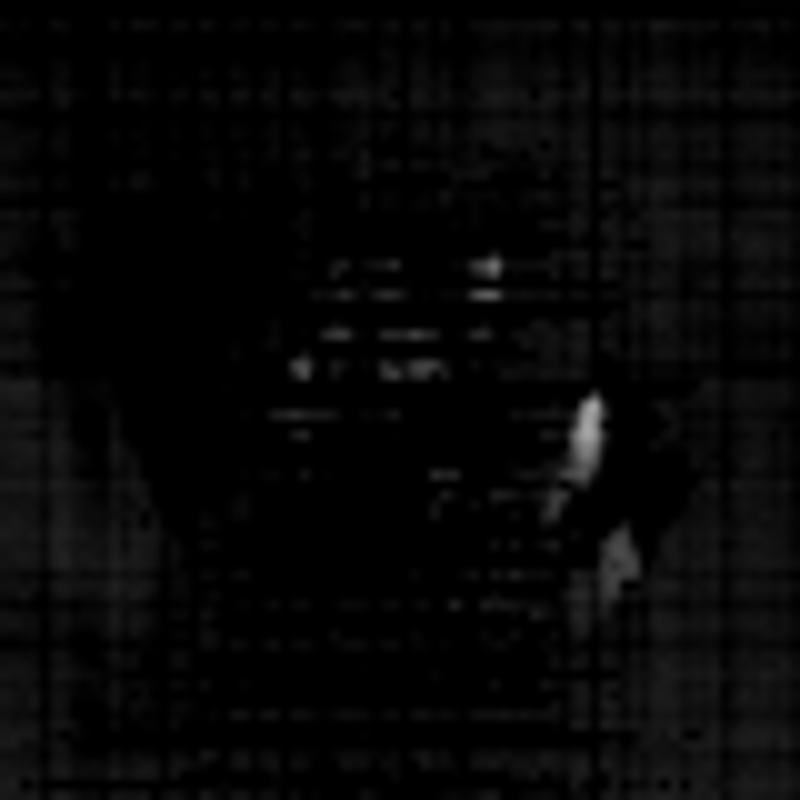

pred: 10.70
labl: 21
diff: 10


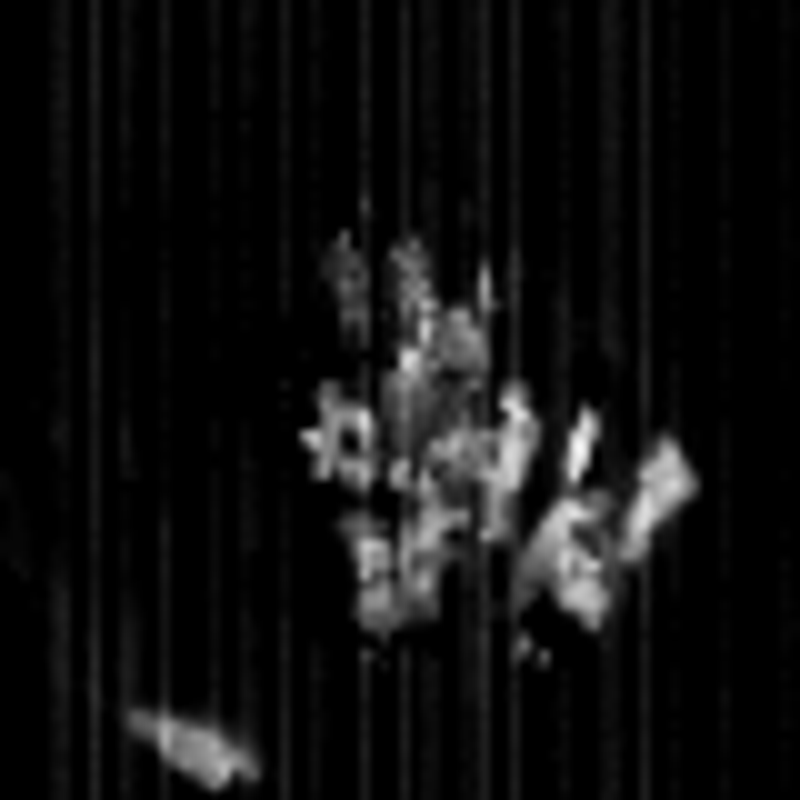

pred: 7.85
labl: 14
diff: 6


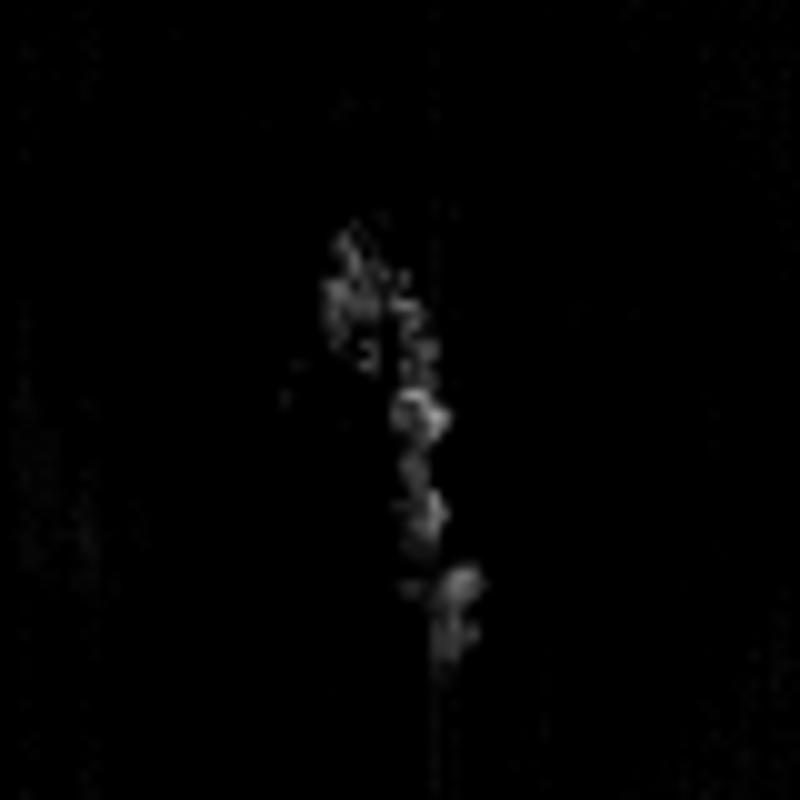

pred: 8.91
labl: 13
diff: 4


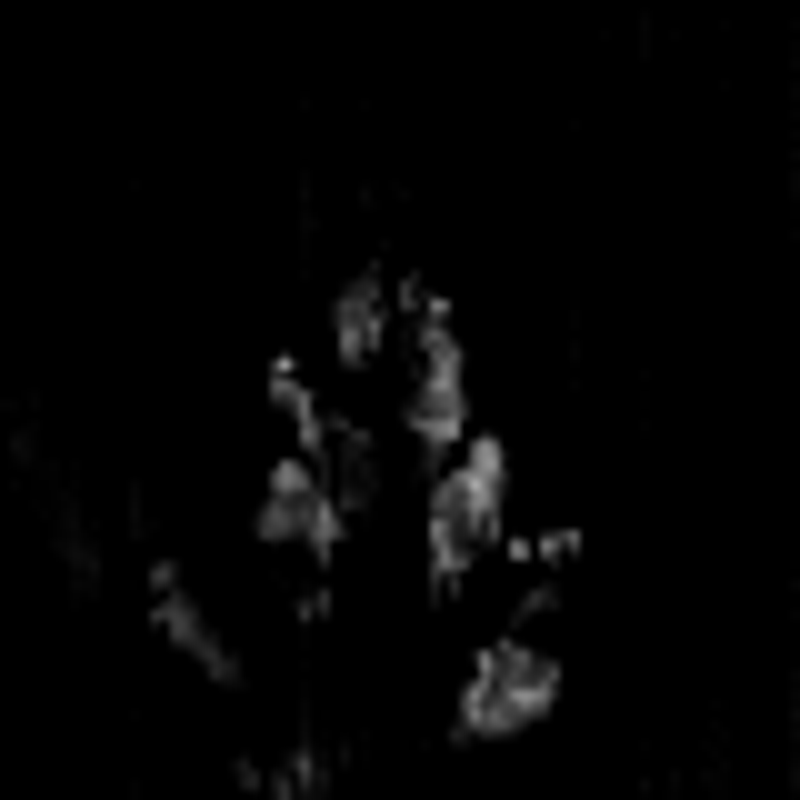

pred: 7.91
labl: 14
diff: 6


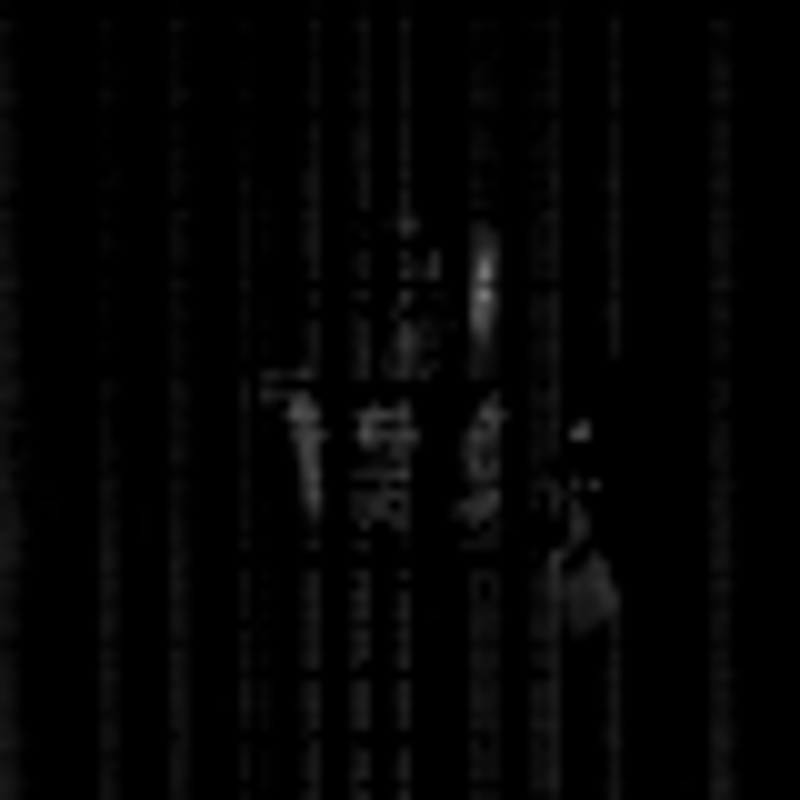

pred: 9.15
labl: 14
diff: 5


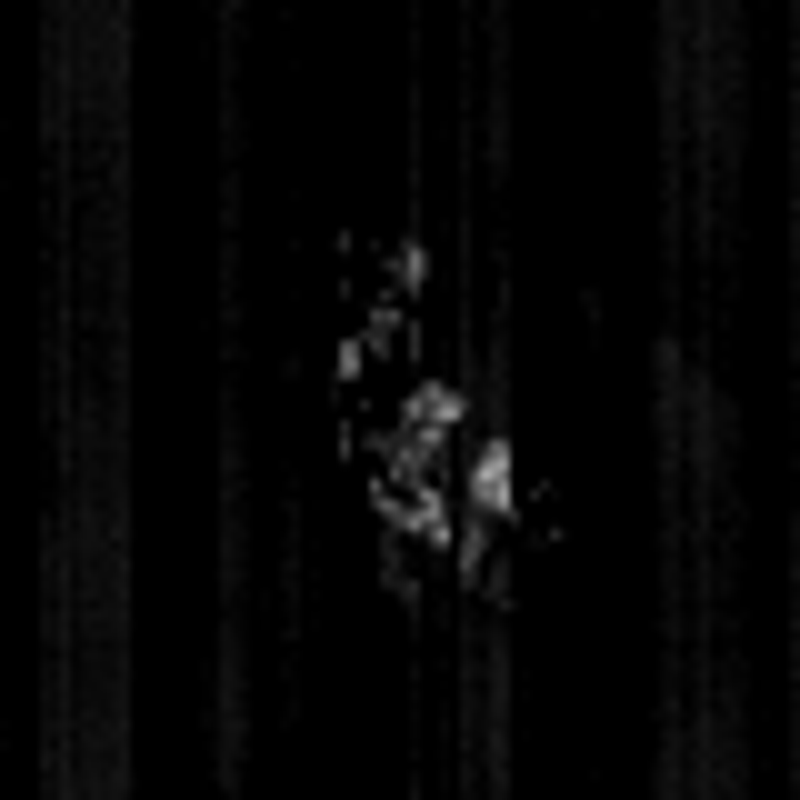

In [255]:
n = len(X2)
ppl = 12
for i in range(0, n, 1):
    if Y2_0[i] > ppl:
        diff = abs(predict_1[i].round(0).astype(int)-Y2_0[i])
        size = 10
        test_img = Image.fromarray((X2[i]*255).reshape(H,W)).convert('L').resize((W*size, H*size))
        print(f"pred: {predict_1[i]:0.2f}")
        print(f"labl: {Y2_0[i]}")
        print(f"diff: {diff}")
        display(test_img)


In [ ]:
# BATCH = 32
# EPOCH = 30
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
# for ind in range(len(lb)):
#     # ind는 label 인덱스
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# x_data = []
# y_data = []
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data).astype(np.float32)
# y_data = np.array(y_data).astype(np.float32)
# X1 = X1.astype(np.float32)
# X2 = X2.astype(np.float32)
#
# for i in range(30):
#     print(i)
#     history = model.fit(X1, X2,
#                         # validation_split=0.2,
#                         validation_data=(x_data, y_data),
#                         batch_size=BATCH,
#                         epochs=EPOCH,
#                         verbose=1,
#                         # callbacks=[es],)
#                         # callbacks=[es, tensorboard_callback], )
#                         )
#     model.save('asdf/' + str(i) + '.h5')

In [ ]:
# epo = 10
# model = tf.keras.models.load_model('asdf/' + str(epo) + '.h5')
# Y2.shape
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
#
#
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
#
# for ind in range(len(lb)):
#
#     # ind는 label 인덱스
#
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# ls_num
#
# x_data = []
# y_data = []
#
#
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data)
# y_data = np.array(y_data)
# x_data.shape
# y_data.shape
#
#
# result = np.argmax(model.predict(x_data), -1)
# cont = 0
# for ind in range(len(result)):
#     if result[ind] == y_data.reshape(-1)[ind]:
#         cont +=1
#
#
# cont
# print(len(ls_num))
# print(cont/len(result))


In [ ]:
TO_TFLITE = 1

if TO_TFLITE == 1:
    save_to_tflite(model, model_save_name)

    # # converter = tf.lite.TFLiteConverter.from_saved_model(model_path_last)
    # converter = tf.lite.TFLiteConverter.from_keras_model(model)
    #
    # tflite_model = converter.convert()
    # with open(f'{model_save_name}.tflite', 'wb') as f:
    #     f.write(tflite_model)